In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import os, json
import warnings
import pymysql
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
insurance_df = pd.read_csv("/Users/dell/Downloads/insurance - insurance.csv")
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### Hypothesis testing
We have been asked to use hypothesis testing to answet the following questions

- Q1. Do smokers have higher insurance charges than non-
smokers?
- Q2. Are men more likely to smoke than women?
- Q3. Do different regions have different charges, on average?

#### Q1: Null hypothesis and Alternative hypothesis

- Null: There is no difference between the charges of smokers to non smokers

- Alternative: There is a difference between the charges to smokers and non smokers


We will either reject the null hypothesis and fail to reject the alternative hypothesis or we reject the alternative hypothesis and fail to reject the null hypothesis. 

In [3]:
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
insurance_df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [5]:
smokers = insurance_df.loc[insurance_df['smoker']== 'yes']
non_smokers = insurance_df.loc[insurance_df['smoker']== 'no']

In [6]:
smokers

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
11,62,female,26.290,0,yes,southeast,27808.72510
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
...,...,...,...,...,...,...,...
1313,19,female,34.700,2,yes,southwest,36397.57600
1314,30,female,23.655,3,yes,northwest,18765.87545
1321,62,male,26.695,0,yes,northeast,28101.33305
1323,42,female,40.370,2,yes,southeast,43896.37630


In [7]:
non_smokers

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
...,...,...,...,...,...,...,...
1332,52,female,44.700,3,no,southwest,11411.68500
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350


In [8]:
#define features
info= smokers['charges']
mean= np.mean(info)
median = np.median(info)

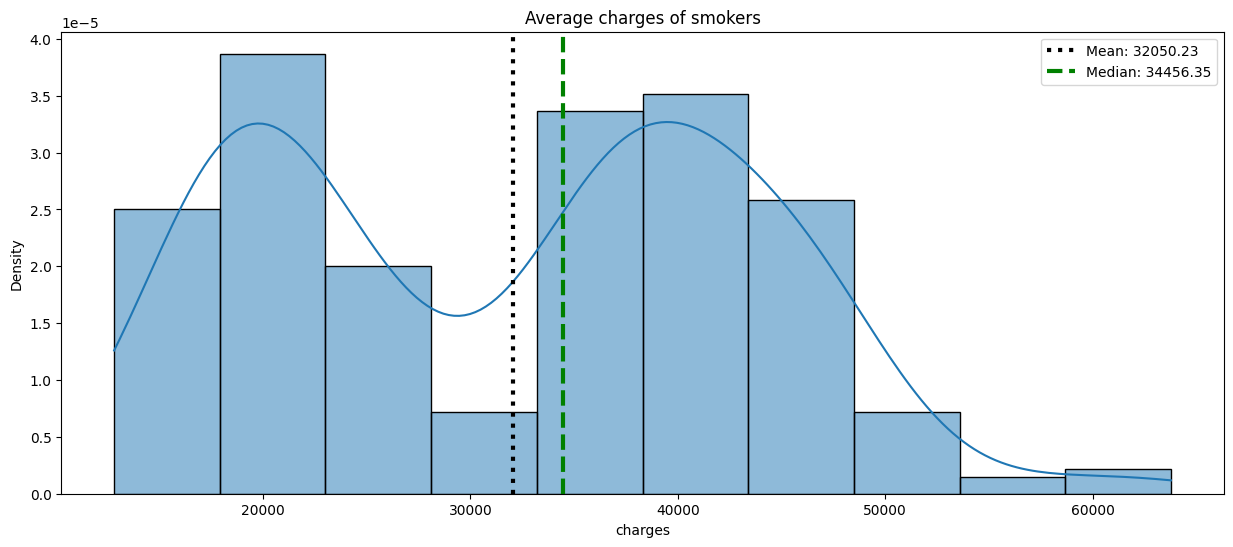

In [9]:
fig, ax = plt.subplots(figsize=(15,6))
sns.histplot(x=info, kde=True, ax=ax, stat='density')
ax.set_title('Average charges of smokers')
ax.axvline(mean,ls=':', color='black', lw=3, label =f"Mean: {mean:.2f}")
ax.axvline(median,ls='--', color='green', lw=3, label =f"Median: {median:.2f}")
ax.legend()

In [10]:
#Define features of opposite group
data = non_smokers['charges']
mean2 = np.mean(data)
median2 = np.median(data)

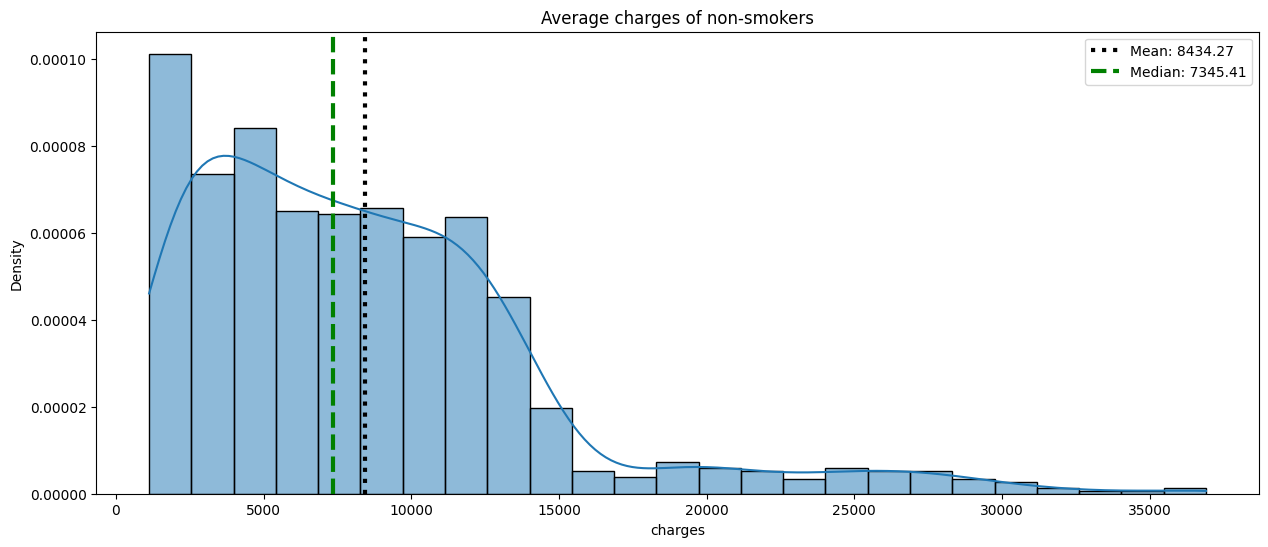

In [11]:
fig, ax = plt.subplots(figsize=(15,6))
sns.histplot(x=data, kde=True, ax=ax, stat='density')
ax.set_title('Average charges of non-smokers')
ax.axvline(mean2,ls=':', color='black', lw=3, label =f"Mean: {mean2:.2f}")
ax.axvline(median2,ls='--', color='green', lw=3, label =f"Median: {median2:.2f}")
ax.legend()

The distribution of data between these groups is vastly different, however the sizes of the groups is also very different as well. 

In [12]:
result = stats.normaltest(info)
print(result)
# is the p-value less than 0.05?
result.pvalue < .05
#pvalue is 0.0000055 which is way lower than .05

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)


True

In [13]:
result = stats.normaltest(data)
print(result)
# is the p-value less than 0.05?
result.pvalue < .05
#pvalue is 0.0000000000019 which is smaller than 0.05

NormaltestResult(statistic=316.4528082392722, pvalue=1.9193129759002216e-69)


True

#### the null hypothesis for the normalcy test we reject the null hypothesis because the pvalue is lower higher than .05 showing the distribution of data is not normal. Independant testing might be more appropriate for this data. 

In [14]:
#seperate data into 2 groups ( has_discount, no discount)
sample = insurance_df.sample(n=50,random_state=42)
smoker_charges = sample.loc[sample['smoker'] == 'yes','charges']
non_smoker_charges = sample.loc[sample['smoker']== 'no', 'charges']
print(f"Smoker (n={len(smoker_charges)}): Mean={np.mean(smoker_charges):.2f}")
print(f"non-smoker (n={len(non_smoker_charges)}): Mean={np.mean(non_smoker_charges):.2f}")

Smoker (n=11): Mean=35439.40
non-smoker (n=39): Mean=7309.48


In this example alone the mean from just 11 samples of smoker data is over 3x as much as the charges for non smokers with a sample of 39. 

In [15]:
#testing for outliers
zscores_f = stats.zscore(smoker_charges)
outliers_f = abs(zscores_f)>3
np.sum(outliers_f)

0

In [16]:
zscores_f = stats.zscore(non_smoker_charges)
outliers_f = abs(zscores_f)>3
np.sum(outliers_f)
#no outliers 

0

In [17]:
#normality testing each group
result_m = stats.normaltest(smoker_charges)
result_m

C:\Users\dell\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


NormaltestResult(statistic=2.209358578032982, pvalue=0.331317122245031)

In [18]:
result_m = stats.normaltest(non_smoker_charges)
result_m

NormaltestResult(statistic=2.6262187199374125, pvalue=0.26898239167805005)

### p values for both are greater than.05 fail to reject null hypothesis and the data distribution is normal. 

In [19]:
results = stats.levene(smoker_charges, non_smoker_charges)
results
#pvalue is 0.000086 which is less than .05 and we reject the numm hypothesis. there is not equal variance in this data. 

LeveneResult(statistic=18.397400827816167, pvalue=8.621214599569032e-05)

In [20]:
# expectations not met so we weill do a t test without sampling 
zscores= stats.zscore(info)
outliers = abs(zscores)>3
np.sum(outliers)
#Smokers has no outliers 

0

In [21]:
zscores= stats.zscore(data)
outliers = abs(zscores)>3
np.sum(outliers)
#non smokers has 24 outliers

24

In [22]:
data = data[(np.abs(stats.zscore(data))< 3)]
#dropped outliers

In [23]:
result = stats.levene(data, info)
result
#no equal variance but well indicate equal_var = false in the t test

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

In [24]:
result = stats.ttest_ind(data, info, equal_var = False)
result
# the pvalue is way smaller that .05 so we reject the null hypothesis. 

Ttest_indResult(statistic=-33.732305987092516, pvalue=2.575322662587431e-104)

# are men more likely to smoke than women

Null hypothesis:There is no difference in the probabily of a man smoking than a woman

Alternative: There is a difference the in the lieklyhood of men smoking than women 

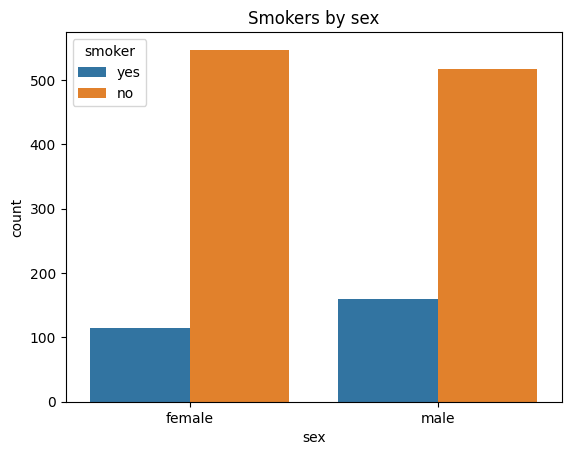

In [25]:
ax = sns.countplot(data= insurance_df, x = 'sex', hue = 'smoker')
ax.set_title('Smokers by sex');

In [26]:
#contingency table
table = pd.crosstab(insurance_df['sex'], insurance_df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [27]:
#chi squared test for categorical probaility 
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [28]:
print(p)
#the pvalue is less than .05 so we reject the null hypothesis and there is a relationship between sex and survival

0.006548143503580696


### charges between region 
The anova test would be the best option since were comparing muliple variables. 

Null: There is no difference in the charges between regions

Alt: Region made a difference on the average charges

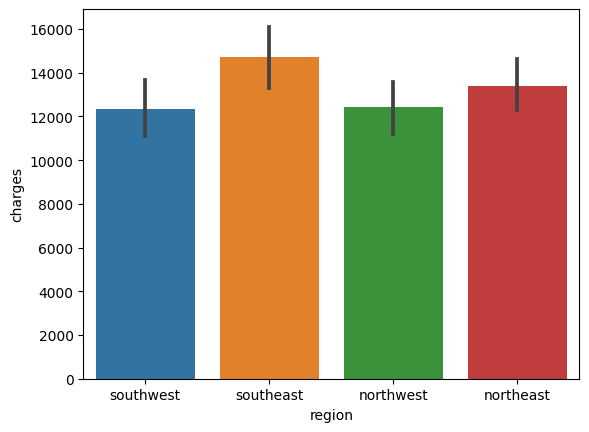

In [29]:
sns.barplot(data=insurance_df, x='region',y='charges');

In [37]:
groups= {}
for i in insurance_df['region'].unique():
    data = insurance_df.loc[insurance_df['region']==i, 'charges']
    
    groups[i]= data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [39]:
norm_results = {}
for i,data in groups.items():
    stat, p = stats.normaltest(data)
    norm_results[i] = {'n': len(data),
                          'p':p,
                          'test stat':stat,}
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [40]:
norm_results_df['sig']= norm_results_df['p']<.05
norm_results_df
#the distribution is not normal

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


In [41]:
stats.levene(*groups.values())
#We rejected equal variance hypothesis <.05

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

In [42]:
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=2.96962669358912, pvalue=0.0308933560705201)

#### there is a difference between the averages of charges between regions. We reject the null hypothesis